In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Load the cleaned dataset
df = pd.read_excel("../Data/MachineLearningRating_v3_cleaned.xlsx")
# Display the first few rows to confirm proper loading
print(d.head())

   UnderwrittenCoverID  PolicyID     TransactionMonth  IsVATRegistered  \
0               145249     12827  2015-03-01 00:00:00             True   
1               145249     12827  2015-05-01 00:00:00             True   
2               145249     12827  2015-07-01 00:00:00             True   
3               145255     12827  2015-05-01 00:00:00             True   
4               145255     12827  2015-07-01 00:00:00             True   

  Citizenship          LegalType Title Language                 Bank  \
0              Close Corporation    Mr  English  First National Bank   
1              Close Corporation    Mr  English  First National Bank   
2              Close Corporation    Mr  English  First National Bank   
3              Close Corporation    Mr  English  First National Bank   
4              Close Corporation    Mr  English  First National Bank   

       AccountType  ...                    ExcessSelected CoverCategory  \
0  Current account  ...             Mobility - 

### Selecting meterics
For our A/B hypothesis testing, the following key performance indicators (KPIs) are selected:
1. **Risk Metrics**: Measured using:
   - Total Claims
   - Total Premiums
2. **Margin Metrics**:
   - Calculated as: `Margin = TotalPremium - TotalClaims`

We will use these metrics to evaluate the impact of different features (e.g., provinces, zip codes, gender) on risk and profit margins.


In [13]:
# Adding a margin column to the dataset for analysis
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

# Display the first few rows to verify
df[['TotalPremium', 'TotalClaims', 'Margin']].head()



,TotalPremium,TotalClaims,Margin
0,21.929825,0.0,21.929825
1,21.929825,0.0,21.929825
2,0.000000,0.0,0.000000
3,512.848070,0.0,512.848070
4,0.000000,0.0,0.000000


### Data Segmentation
We define:
- **Group A (Control Group)**: Plans without a specific feature.
- **Group B (Test Group)**: Plans with a specific feature.

For example:
- By `Gender` to test for differences between `Male` and `Not specified`.
- By `Province` to test for differences in `TotalPremium`.

Key segments ensure no significant differences beyond the tested feature.


In [14]:
# Data segmentation by gender
group_a_gender = df[df['Gender'] == 'Male']  # Control Group
group_b_gender = df[df['Gender'] == 'Not specified']  # Test Group

# Data segmentation by province
group_a_province = df[df['Province'].isin(['Gauteng', 'Western Cape'])]  # Control Group
group_b_province = df[df['Province'].isin(['KwaZulu-Natal', 'Free State'])]  # Test Group

print(f"Group A Gender: {group_a_gender.shape[0]} entries")
print(f"Group B Gender: {group_b_gender.shape[0]} entries")

print(f"Group A Province: {group_a_province.shape[0]} entries")
print(f"Group B Province: {group_b_province.shape[0]} entries")


Group A Gender: 1373 entries
Group B Gender: 39210 entries
Group A Province: 21341 entries
Group B Province: 11996 entries


### Statistical Testing

We’ll perform the following tests:

    Risk Differences Across Provinces
    Use a chi-squared test to check if there is a significant difference in risk (TotalClaims > 0) across provinces.

    Risk Differences Between Genders
    Use a chi-squared test to check if there is a significant difference in risk (TotalClaims > 0) between genders.

    Margin Differences Between Zip Codes
    Use a t-test to check if there are significant differences in margins between zip codes.

In [15]:
# Risk defined as TotalClaims > 0
df['Risk'] = df['TotalClaims'] > 0

# Observed frequencies for provinces
province_risk_table = pd.crosstab(df['Province'], df['Risk'])

# Perform chi-squared test
from scipy.stats import chi2_contingency

chi2_stat, p_value, dof, expected = chi2_contingency(province_risk_table)
print(f"Chi-Squared Test for Provinces:")
print(f"Chi2 Stat: {chi2_stat}, P-Value: {p_value}")
if p_value < 0.05:
    print("Reject the null hypothesis: Significant risk differences across provinces.")
else:
    print("Fail to reject the null hypothesis: No significant risk differences across provinces.")


Chi-Squared Test for Provinces:
Chi2 Stat: 31.906931264095423, P-Value: 9.678499718400662e-05
Reject the null hypothesis: Significant risk differences across provinces.


In [16]:
# Observed frequencies for gender
gender_risk_table = pd.crosstab(df['Gender'], df['Risk'])

# Perform chi-squared test
chi2_stat_gender, p_value_gender, dof_gender, expected_gender = chi2_contingency(gender_risk_table)
print(f"Chi-Squared Test for Gender:")
print(f"Chi2 Stat: {chi2_stat_gender}, P-Value: {p_value_gender}")
if p_value_gender < 0.05:
    print("Reject the null hypothesis: Significant risk differences between genders.")
else:
    print("Fail to reject the null hypothesis: No significant risk differences between genders.")


Chi-Squared Test for Gender:
Chi2 Stat: 13.56934536783509, P-Value: 0.00022990954873999017
Reject the null hypothesis: Significant risk differences between genders.


In [17]:
# Grouping margins by zip codes
zip_code_groups = df.groupby('PostalCode')['Margin']

# Calculate the mean and variance of margins for zip codes
zip_code_stats = zip_code_groups.agg(['mean', 'var']).dropna()

# Select two random zip codes for t-test
zip_a, zip_b = zip_code_stats.index[:2]  # Replace with specific zip codes if needed
margin_a = df[df['PostalCode'] == zip_a]['Margin']
margin_b = df[df['PostalCode'] == zip_b]['Margin']

# Perform t-test
from scipy.stats import ttest_ind

t_stat, p_value_ttest = ttest_ind(margin_a, margin_b, equal_var=False)  # Assume unequal variance
print(f"T-Test for Margins Between Zip Codes {zip_a} and {zip_b}:")
print(f"T-Stat: {t_stat}, P-Value: {p_value_ttest}")
if p_value_ttest < 0.05:
    print("Reject the null hypothesis: Significant margin differences between zip codes.")
else:
    print("Fail to reject the null hypothesis: No significant margin differences between zip codes.")


T-Test for Margins Between Zip Codes 1 and 4:
T-Stat: 2.315403348398686, P-Value: 0.0245734400434533
Reject the null hypothesis: Significant margin differences between zip codes.


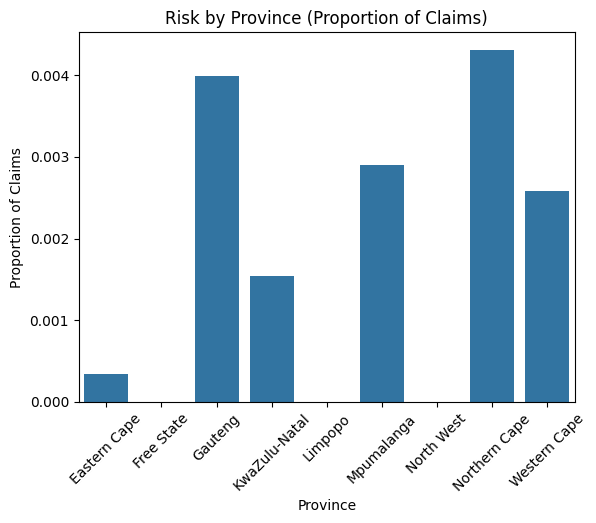

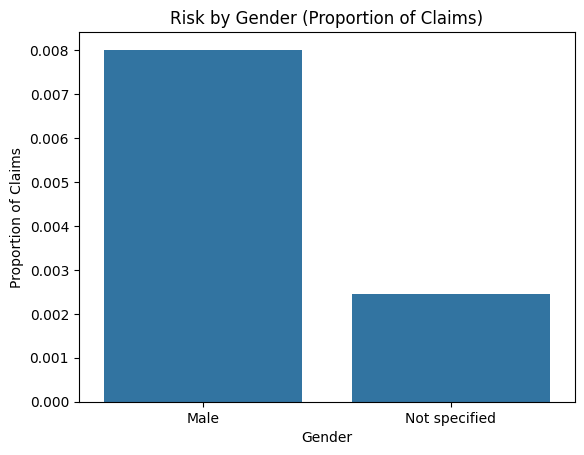

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Proportion of claims per province
province_risk = df.groupby('Province')['TotalClaims'].apply(lambda x: (x > 0).mean()).reset_index()
sns.barplot(x='Province', y='TotalClaims', data=province_risk)
plt.title('Risk by Province (Proportion of Claims)')
plt.xlabel('Province')
plt.ylabel('Proportion of Claims')
plt.xticks(rotation=45)
plt.show()

# Proportion of claims by Gender
gender_risk = df.groupby('Gender')['TotalClaims'].apply(lambda x: (x > 0).mean()).reset_index()
sns.barplot(x='Gender', y='TotalClaims', data=gender_risk)
plt.title('Risk by Gender (Proportion of Claims)')
plt.xlabel('Gender')
plt.ylabel('Proportion of Claims')
plt.show()


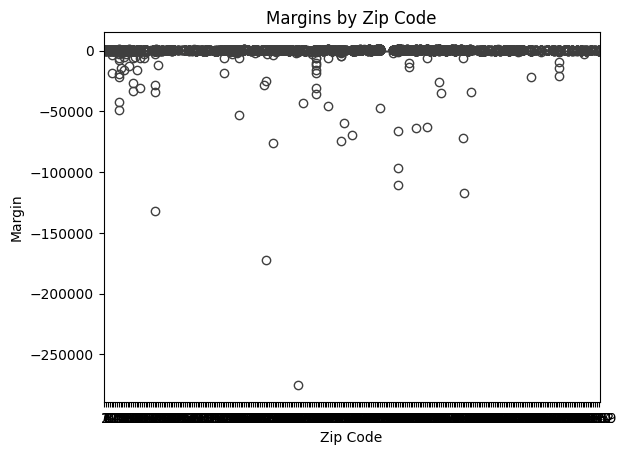

In [22]:
# Calculate margin for each row
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

# Boxplot for margins by zip code
sns.boxplot(x='PostalCode', y='Margin', data=df)
plt.title('Margins by Zip Code')
plt.xlabel('Zip Code')
plt.ylabel('Margin')
plt.show()


In [23]:
# Proportion of claims per province
province_risk = df.groupby('Province')['TotalClaims'].apply(lambda x: (x > 0).mean()).reset_index()
province_risk.columns = ['Province', 'Claim Proportion']
print(province_risk)


        Province  Claim Proportion
0   Eastern Cape          0.000347
1     Free State          0.000000
2        Gauteng          0.003996
3  KwaZulu-Natal          0.001538
4        Limpopo          0.000000
5     Mpumalanga          0.002895
6     North West          0.000000
7  Northern Cape          0.004310
8   Western Cape          0.002584


In [24]:
# Proportion of claims by Gender
gender_risk = df.groupby('Gender')['TotalClaims'].apply(lambda x: (x > 0).mean()).reset_index()
gender_risk.columns = ['Gender', 'Claim Proportion']
print(gender_risk)


          Gender  Claim Proportion
0           Male          0.008012
1  Not specified          0.002448


In [25]:
# Calculate margin for each row
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

# Group by PostalCode and get mean and variance of margins
margin_stats_by_zip = df.groupby('PostalCode')['Margin'].agg(['mean', 'var']).reset_index()
print(margin_stats_by_zip)


     PostalCode        mean           var
0             1  114.301046  5.399385e+04
1             4   44.935055  2.313861e+04
2             8  102.379462  3.661106e+04
3            22   59.419202  3.059932e+04
4            64 -172.866985  3.829925e+06
..          ...         ...           ...
272        9725  139.756877  4.768375e+04
273        9730   89.965689  1.241552e+04
274        9744  175.104079  9.181503e+04
275        9762   43.859649  0.000000e+00
276        9869   53.620836  1.115390e+04

[277 rows x 3 columns]
